In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import statsmodels.api as sm

In [2]:
#Load Data
dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')
la_2025_asset_summary = pd.read_csv(r'../../data/processed/la_2025_asset_summary.csv')
population_summary = pd.read_csv(r'../../data/processed/population_summary_by_la.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_40616\696023224.py:2: DtypeWarning: Columns (25,29,32,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')


In [3]:
#Charity Summary
charity_summary = dataset.groupby('local_authority').agg(
    total_charities=('registered_charity_number', 'count'),
    percent_land_holding=('charity_has_land', 'mean'),
    median_income=('latestIncome', 'median'),
    removal_rate=('charity_status', lambda x: (x == 'inactive').mean()),
).reset_index()

Total number of charity data: 351,959
Total number of charities removed: 180,968
Number of charities removed per year:
1961.0: 295
1962.0: 91
1963.0: 89
1964.0: 116
1965.0: 96
1966.0: 106
1967.0: 87
1968.0: 83
1969.0: 59
1970.0: 79
1971.0: 81
1972.0: 124
1973.0: 141
1974.0: 143
1975.0: 133
1976.0: 119
1977.0: 188
1978.0: 152
1979.0: 123
1980.0: 145
1981.0: 124
1982.0: 153
1983.0: 142
1984.0: 157
1985.0: 141
1986.0: 157
1987.0: 184
1988.0: 253
1989.0: 208
1990.0: 135
1991.0: 4,921
1992.0: 11,406
1993.0: 6,826
1994.0: 3,640
1995.0: 4,365
1996.0: 7,801
1997.0: 5,286
1998.0: 3,463
1999.0: 3,562
2000.0: 8,636
2001.0: 4,802
2002.0: 3,872
2003.0: 3,673
2004.0: 4,620
2005.0: 4,086
2006.0: 3,721
2007.0: 4,011
2008.0: 5,575
2009.0: 12,395
2010.0: 5,588
2011.0: 6,198
2012.0: 4,066
2013.0: 4,157
2014.0: 3,859
2015.0: 4,326
2016.0: 4,055
2017.0: 4,215
2018.0: 4,957
2019.0: 5,780
2020.0: 3,812
2021.0: 3,592
2022.0: 5,534
2023.0: 4,221
2024.0: 4,083
2025.0: 1,760


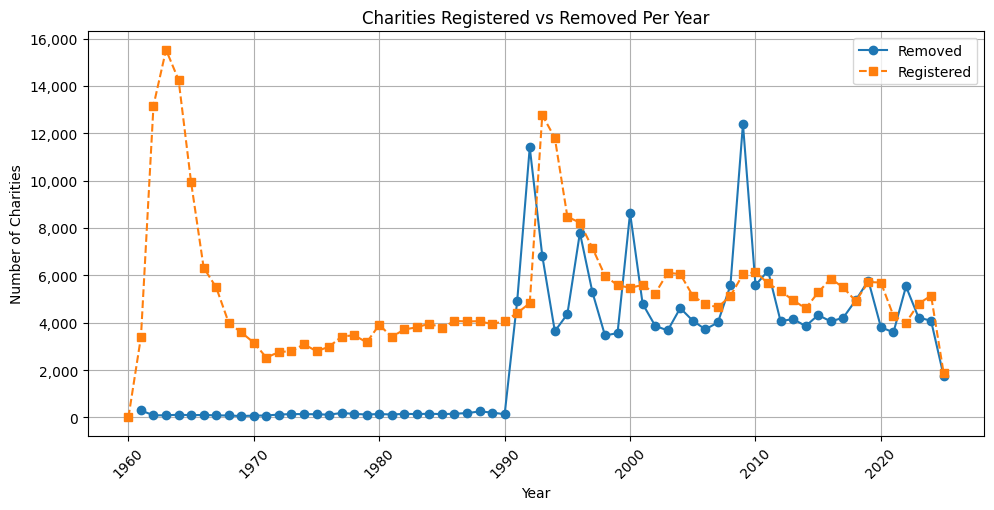

In [73]:
# Parse dates
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')

# Count removals per year
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()

# Count registrations per year
registered_by_year = dataset['date_of_registration'].dt.year.value_counts().sort_index()

# Print summary
print(f"Total number of charity data: {dataset['charity_status'].count():,}")
print(f"Total number of charities removed: {removed_by_year.sum():,}")
print("Number of charities removed per year:")
for year, count in removed_by_year.items():
    print(f"{year}: {count:,}")

# Plot both lines
plt.figure(figsize=(10, 5))
plt.plot(removed_by_year.index, removed_by_year.values, marker='o', linestyle='-', label='Removed')
plt.plot(registered_by_year.index, registered_by_year.values, marker='s', linestyle='--', label='Registered')

plt.title('Charities Registered vs Removed Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

Total number of charity data: 351,959
Total number of charities removed: 180,968
Number of charities removed per year:
1961.0: 295
1962.0: 91
1963.0: 89
1964.0: 116
1965.0: 96
1966.0: 106
1967.0: 87
1968.0: 83
1969.0: 59
1970.0: 79
1971.0: 81
1972.0: 124
1973.0: 141
1974.0: 143
1975.0: 133
1976.0: 119
1977.0: 188
1978.0: 152
1979.0: 123
1980.0: 145
1981.0: 124
1982.0: 153
1983.0: 142
1984.0: 157
1985.0: 141
1986.0: 157
1987.0: 184
1988.0: 253
1989.0: 208
1990.0: 135
1991.0: 4,921
1992.0: 11,406
1993.0: 6,826
1994.0: 3,640
1995.0: 4,365
1996.0: 7,801
1997.0: 5,286
1998.0: 3,463
1999.0: 3,562
2000.0: 8,636
2001.0: 4,802
2002.0: 3,872
2003.0: 3,673
2004.0: 4,620
2005.0: 4,086
2006.0: 3,721
2007.0: 4,011
2008.0: 5,575
2009.0: 12,395
2010.0: 5,588
2011.0: 6,198
2012.0: 4,066
2013.0: 4,157
2014.0: 3,859
2015.0: 4,326
2016.0: 4,055
2017.0: 4,215
2018.0: 4,957
2019.0: 5,780
2020.0: 3,812
2021.0: 3,592
2022.0: 5,534
2023.0: 4,221
2024.0: 4,083
2025.0: 1,760


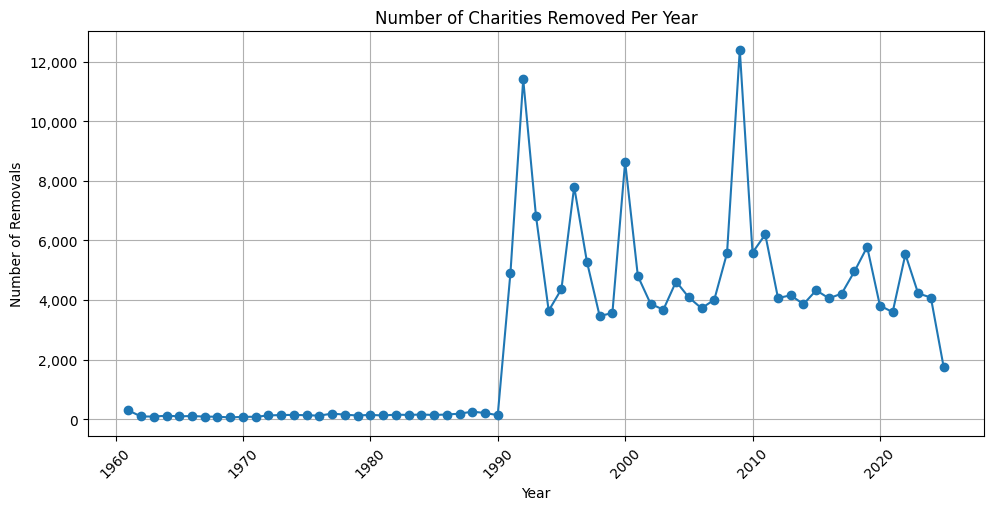

In [4]:
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()
print(f'Total number of charity data: {dataset['charity_status'].count():,}')
print(f"Total number of charities removed: {removed_by_year.sum():,}")
print("Number of charities removed per year:")
for year, count in removed_by_year.items():
    print(f"{year}: {count:,}")

plt.figure(figsize=(10, 5))
plt.plot(removed_by_year.index, removed_by_year.values, marker='o', linestyle='-')
plt.title('Number of Charities Removed Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Removals')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

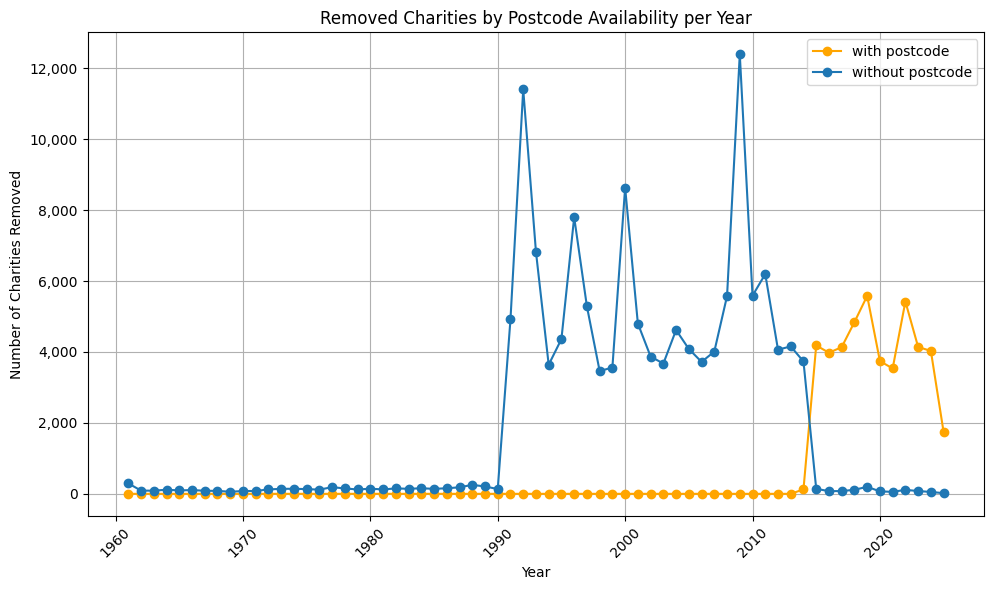

In [5]:
# Ensure datetime conversion
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

# Filter removed charities
removed = dataset[dataset['date_of_removal'].notnull()].copy()

# Create postcode status category
def classify_postcode(x):
    if pd.isnull(x):
        return 'without postcode'
    x_str = str(x).strip().lower()
    return 'with postcode' if x_str not in ['', 'nan', 'none'] else 'without postcode'

removed['postcode_status'] = removed['postcode'].apply(classify_postcode)

# Extract year of removal
removed['removal_year'] = removed['date_of_removal'].dt.year

# Group by year and postcode status
removed_by_year_postcode = (
    removed.groupby(['removal_year', 'postcode_status'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plotting
plt.figure(figsize=(10, 6))
color_map = {
    'without postcode': '#1f77b4',
    'with postcode': 'orange'
}
for category in removed_by_year_postcode.columns:
    plt.plot(
        removed_by_year_postcode.index,
        removed_by_year_postcode[category],
        marker='o',
        label=category,
        color=color_map.get(category, 'grey')  # fallback colour if unexpected category
    )
plt.title('Removed Charities by Postcode Availability per Year')
plt.xlabel('Year')
plt.ylabel('Number of Charities Removed')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_40616\3162599160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive['removed_by_year'] = inactive['date_of_removal'].dt.year
C:\Users\User\AppData\Local\Temp\ipykernel_40616\3162599160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive['land_category'] = inactive['charity_has_land'].map({True: 'with land', False: 'without land'})
C:\Users\User\AppData\Local\Temp\ipykernel_40616\3162599160.py:7: SettingWithCopyWarning: 
A value is trying to be se

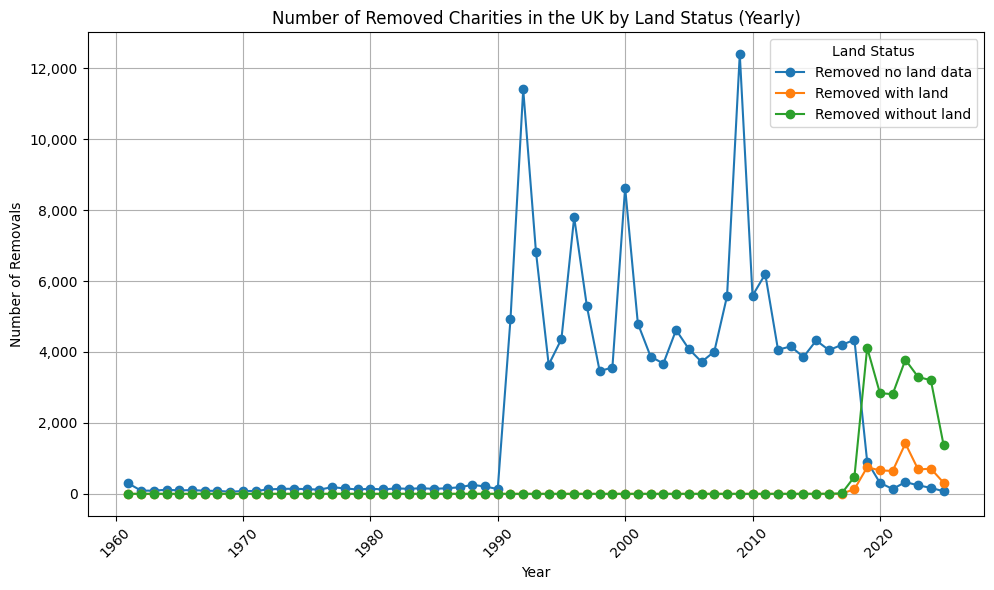

In [6]:
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
inactive = dataset[dataset['charity_status'] == 'inactive']
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()
inactive['removed_by_year'] = inactive['date_of_removal'].dt.year

inactive['land_category'] = inactive['charity_has_land'].map({True: 'with land', False: 'without land'})
inactive['land_category'] = inactive['land_category'].fillna('no land data')

# Group by year and land category
removed_by_year_land = (
    inactive
    .groupby(['removed_by_year', 'land_category'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plotting
plt.figure(figsize=(10, 6))
for column in removed_by_year_land.columns:
    plt.plot(removed_by_year_land.index, removed_by_year_land[column], marker='o', label=f"Removed {column}")

plt.title('Number of Removed Charities in the UK by Land Status (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Removals')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Land Status')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_40616\992193523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed['age_at_removal'] = (removed['date_of_removal'] - removed['date_of_registration']).dt.days // 365
C:\Users\User\AppData\Local\Temp\ipykernel_40616\992193523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed['age_category'] = pd.cut(removed['age_at_removal'], bins=bins, labels=labels, right=True)
C:\Users\User\AppData\Local\Temp\ipykernel_40616\992193523.py:14: SettingWithCopyWarn

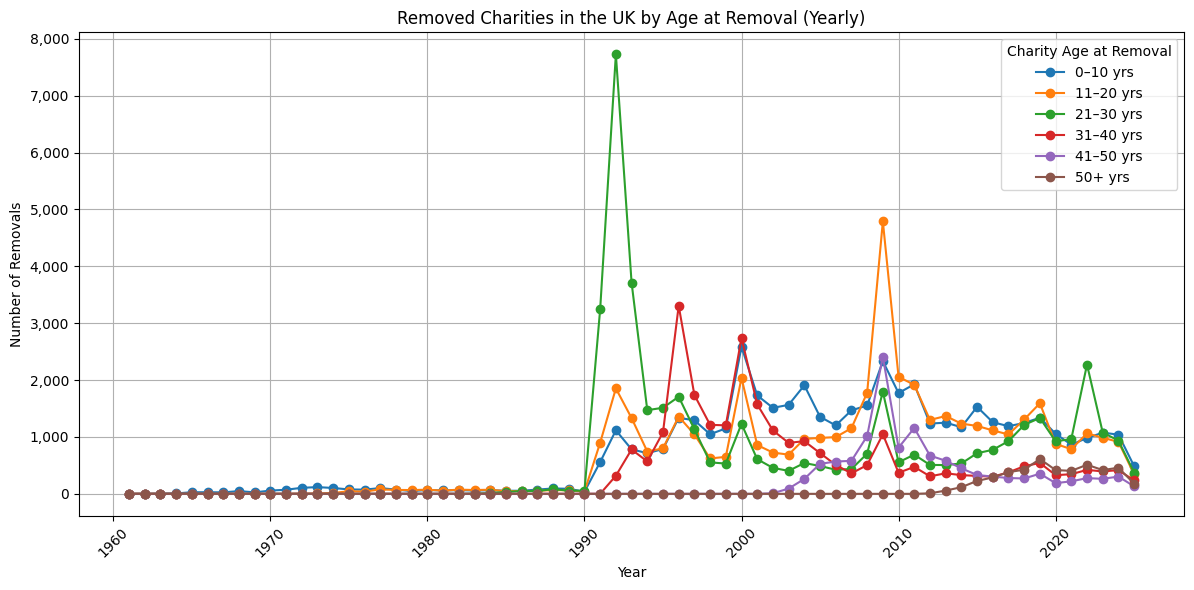

In [7]:
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

removed = dataset[dataset['date_of_removal'].notnull()]

removed['age_at_removal'] = (removed['date_of_removal'] - removed['date_of_registration']).dt.days // 365

# Bin into age categories
bins = [0, 10, 20, 30, 40, 50, 1000]
labels = ['0–10 yrs', '11–20 yrs', '21–30 yrs', '31–40 yrs', '41–50 yrs', '50+ yrs']
removed['age_category'] = pd.cut(removed['age_at_removal'], bins=bins, labels=labels, right=True)

# Add year column
removed['year'] = removed['date_of_removal'].dt.year

# Group by year and age category
removed_by_year_age = (
    removed
    .groupby(['year', 'age_category'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plotting
plt.figure(figsize=(12, 6))
for column in removed_by_year_age.columns:
    plt.plot(removed_by_year_age.index, removed_by_year_age[column], marker='o', label=f"{column}")

plt.title('Removed Charities in the UK by Age at Removal (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Removals')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Charity Age at Removal')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


Total number of charity data: 351,959
Total number of charities removed: 44,575
Number of charities removed per year:
2015.0: 4,326
2016.0: 4,055
2017.0: 4,215
2018.0: 4,957
2019.0: 5,780
2020.0: 3,812
2021.0: 3,592
2022.0: 5,534
2023.0: 4,221
2024.0: 4,083


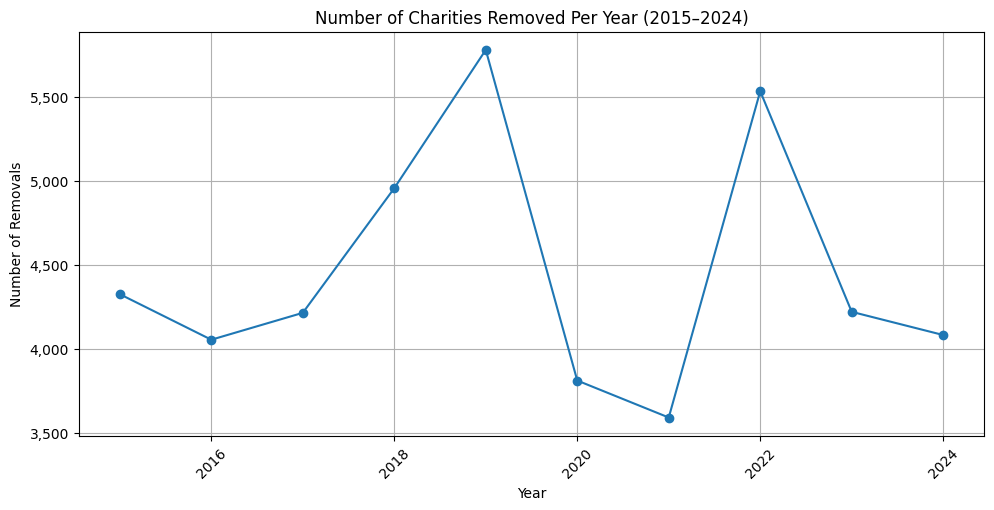

In [8]:
# Ensure datetime conversion
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

# Count removals by year
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()

# ✅ Filter for years 2015 to 2024
removed_by_year = removed_by_year[(removed_by_year.index >= 2015) & (removed_by_year.index <= 2024)]

# Print summary
print(f'Total number of charity data: {dataset["charity_status"].count():,}')
print(f"Total number of charities removed: {removed_by_year.sum():,}")
print("Number of charities removed per year:")
for year, count in removed_by_year.items():
    print(f"{year}: {count:,}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(removed_by_year.index, removed_by_year.values, marker='o', linestyle='-', color='#1f77b4')
plt.title('Number of Charities Removed Per Year (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Number of Removals')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


Total number of charity data: 351,959
Total number of charities removed: 44,575
Number of charities removed per year:
2015.0: 4,326
2016.0: 4,055
2017.0: 4,215
2018.0: 4,957
2019.0: 5,780
2020.0: 3,812
2021.0: 3,592
2022.0: 5,534
2023.0: 4,221
2024.0: 4,083


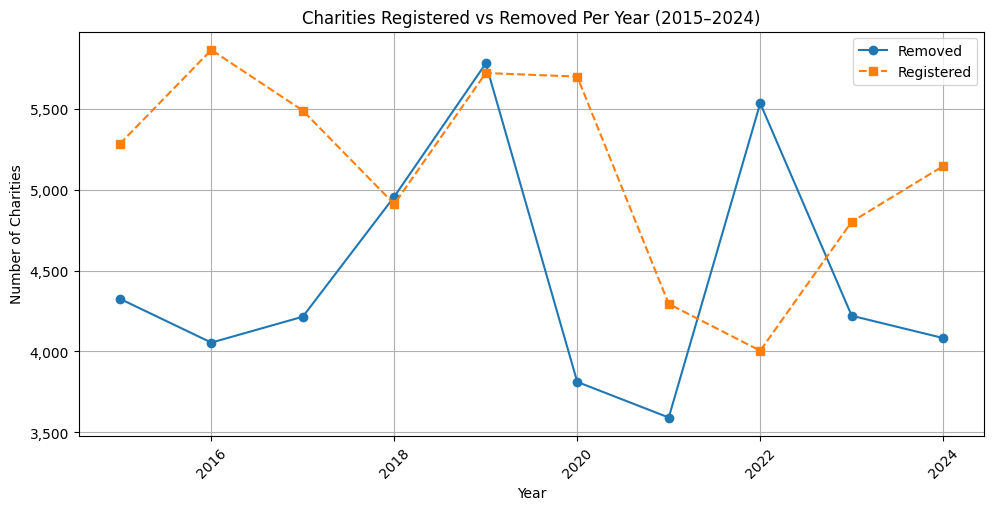

In [74]:

# Ensure datetime
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')

# Count per year
removed_by_year = dataset['date_of_removal'].dt.year.value_counts().sort_index()
registered_by_year = dataset['date_of_registration'].dt.year.value_counts().sort_index()

# Filter both to 2015–2024
removed_by_year = removed_by_year[(removed_by_year.index >= 2015) & (removed_by_year.index <= 2024)]
registered_by_year = registered_by_year[(registered_by_year.index >= 2015) & (registered_by_year.index <= 2024)]

# Print summary
print(f'Total number of charity data: {dataset["charity_status"].count():,}')
print(f"Total number of charities removed: {removed_by_year.sum():,}")
print("Number of charities removed per year:")
for year, count in removed_by_year.items():
    print(f"{year}: {count:,}")

# Plot both lines
plt.figure(figsize=(10, 5))
plt.plot(removed_by_year.index, removed_by_year.values, marker='o', linestyle='-', color='#1f77b4', label='Removed')
plt.plot(registered_by_year.index, registered_by_year.values, marker='s', linestyle='--', color='#ff7f0e', label='Registered')

plt.title('Charities Registered vs Removed Per Year (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Number of Charities')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

In [9]:
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['removal_year'] = dataset['date_of_removal'].dt.year

removed = dataset[dataset['removal_year'].notnull() & dataset['local_authority'].notnull()]

removed_by_year_la = (
    removed
    .groupby(['local_authority', 'removal_year'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# ✅ Keep only years 2015–2024
years = list(range(2015, 2025))
removed_by_year_la = removed_by_year_la[removed_by_year_la.columns.intersection(years)]

# ✅ Recalculate total and sort
removed_by_year_la['Total'] = removed_by_year_la.sum(axis=1)
removed_by_year_la = removed_by_year_la.sort_values(by='Total', ascending=False)

print("Removed Charities per Year per Local Authority (2015–2024):")
print(removed_by_year_la.head(10))


Removed Charities per Year per Local Authority (2015–2024):
removal_year     2015.0  2016.0  2017.0  2018.0  2019.0  2020.0  2021.0  \
local_authority                                                           
North Yorkshire      59      74      88      88      99      58      74   
Westminster          81      66      80      80     106      67      58   
Birmingham           68      50      53      70      98      39      38   
Somerset             54      61      62      66      69      61      56   
Cornwall             39      54      55      66      69      38      61   
Wiltshire            47      43      54      63      64      63      42   
Buckinghamshire      39      55      56      61      73      45      51   
Camden               46      46      48      49      80      46      39   
Barnet               53      41      46      48      68      44      28   
Dorset               44      54      38      54      43      23      42   

removal_year     2022.0  2023.0  2024.0

In [10]:
# Step 1: Define year range
years = list(range(2015, 2025))

# Step 2: Calculate percentage change across years
removed_pct_change = removed_by_year_la[years].pct_change(axis=1) * 100

# Step 3: Round for readability
removed_pct_change = removed_pct_change.round(2)
removed_pct_change

removal_year,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
local_authority,,,,,,,,,,
North Yorkshire,NaN,25.42,18.92,0.00,12.50,-41.41,27.59,20.27,-32.58,40.00
Westminster,NaN,-18.52,21.21,0.00,32.50,-36.79,-13.43,24.14,6.94,-24.68
Birmingham,NaN,-26.47,6.00,32.08,40.00,-60.20,-2.56,128.95,-45.98,10.64
Somerset,NaN,12.96,1.64,6.45,4.55,-11.59,-8.20,1.79,-1.75,-3.57
Cornwall,NaN,38.46,1.85,20.00,4.55,-44.93,60.53,22.95,-40.00,-6.67
...,...,...,...,...,...,...,...,...,...,...
Orkney Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
South Lanarkshire,NaN,-100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Armagh City, Banbridge and Craigavon",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [ ]:
# Already sorted by total, so just keep top 50
top_50_removed = removed_by_year_la.head(15).drop(columns='Total')
# This is now a DataFrame of shape (50, 10) with years 2015–2024

removed_pct_change = top_50_removed.pct_change(axis=1) * 100
removed_pct_change = removed_pct_change.round(2)

removed_pct_change_long = (
    removed_pct_change
    .reset_index()
    .melt(id_vars='local_authority', var_name='year', value_name='pct_change')
)
removed_pct_change

removal_year,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
local_authority,,,,,,,,,,
North Yorkshire,NaN,25.42,18.92,0.00,12.50,-41.41,27.59,20.27,-32.58,40.00
Westminster,NaN,-18.52,21.21,0.00,32.50,-36.79,-13.43,24.14,6.94,-24.68
Birmingham,NaN,-26.47,6.00,32.08,40.00,-60.20,-2.56,128.95,-45.98,10.64
Somerset,NaN,12.96,1.64,6.45,4.55,-11.59,-8.20,1.79,-1.75,-3.57
Cornwall,NaN,38.46,1.85,20.00,4.55,-44.93,60.53,22.95,-40.00,-6.67
Wiltshire,NaN,-8.51,25.58,16.67,1.59,-1.56,-33.33,38.10,-15.52,4.08
Buckinghamshire,NaN,41.03,1.82,8.93,19.67,-38.36,13.33,5.88,-5.56,-7.84
Camden,NaN,0.00,4.35,2.08,63.27,-42.50,-15.22,53.85,-6.67,8.93
Barnet,NaN,-22.64,12.20,4.35,41.67,-35.29,-36.36,35.71,7.89,2.44


In [55]:
def highlight_top2_bottom2(row):
    # Ignore NaNs
    sorted_vals = row.dropna().sort_values(ascending=False)
    top2 = sorted_vals[:2].values
    bottom2 = sorted_vals[-2:].values

    return [
        'color: red; font-weight: bold' if val in top2
        else 'color: blue; font-weight: bold' if val in bottom2
        else ''
        for val in row
    ]
# Make sure columns are int
removed_pct_change.columns = removed_pct_change.columns.astype(int)

# Drop 2015 column
removed_pct_change_clean = removed_pct_change.drop(columns=[2015])

# Apply styling
styled_wide = removed_pct_change_clean.style.apply(highlight_top2_bottom2, axis=1)


In [56]:
styled_wide

removal_year,2016,2017,2018,2019,2020,2021,2022,2023,2024
local_authority,,,,,,,,,
North Yorkshire,25.420000,18.920000,0.000000,12.500000,-41.410000,27.590000,20.270000,-32.580000,40.000000
Westminster,-18.520000,21.210000,0.000000,32.500000,-36.790000,-13.430000,24.140000,6.940000,-24.680000
Birmingham,-26.470000,6.000000,32.080000,40.000000,-60.200000,-2.560000,128.950000,-45.980000,10.640000
Somerset,12.960000,1.640000,6.450000,4.550000,-11.590000,-8.200000,1.790000,-1.750000,-3.570000
Cornwall,38.460000,1.850000,20.000000,4.550000,-44.930000,60.530000,22.950000,-40.000000,-6.670000
Wiltshire,-8.510000,25.580000,16.670000,1.590000,-1.560000,-33.330000,38.100000,-15.520000,4.080000
Buckinghamshire,41.030000,1.820000,8.930000,19.670000,-38.360000,13.330000,5.880000,-5.560000,-7.840000
Camden,0.000000,4.350000,2.080000,63.270000,-42.500000,-15.220000,53.850000,-6.670000,8.930000
Barnet,-22.640000,12.200000,4.350000,41.670000,-35.290000,-36.360000,35.710000,7.890000,2.440000


In [59]:
# 1. Drop 'Total' column if exists
yearly_data = removed_by_year_la.drop(columns='Total')

# 2. General trend: total removals per year (across all councils)
general_trend = yearly_data.sum(axis=0)

# 3. % change in general trend year-on-year
general_pct_change = general_trend.pct_change() * 100
general_pct_change = general_pct_change.round(2)
print("📈 General % Change in Charity Removals per Year:")
print(general_pct_change)
# 4. Get top 15 councils
top15 = removed_by_year_la.head(15).drop(columns='Total')

# 5. Calculate % change for each
top15_pct_change = top15.pct_change(axis=1) * 100
top15_pct_change = top15_pct_change.round(2)
# 6. Subtract general trend to get deviation
deviation_from_general = top15_pct_change.subtract(general_pct_change, axis=1)
strong_deviations = deviation_from_general[deviation_from_general.abs() > 40]

print("📌 Strong Deviations (>±40% from general trend):")
print(strong_deviations.dropna(how='all'))


📈 General % Change in Charity Removals per Year:
removal_year
2015.0      NaN
2016.0    -4.60
2017.0     3.84
2018.0    17.11
2019.0    15.13
2020.0   -32.94
2021.0    -5.19
2022.0    53.16
2023.0   -23.62
2024.0    -2.84
dtype: float64
📌 Strong Deviations (>±40% from general trend):
removal_year      2015.0  2016.0  2017.0  2018.0  2019.0  2020.0  2021.0  \
local_authority                                                            
North Yorkshire      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Birmingham           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Somerset             NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cornwall             NaN   43.06     NaN     NaN     NaN     NaN   65.72   
Buckinghamshire      NaN   45.63     NaN     NaN     NaN     NaN     NaN   
Camden               NaN     NaN     NaN     NaN   48.14     NaN     NaN   
Dorset               NaN     NaN     NaN     NaN     NaN     NaN   87.80   
Bristol, City of     NaN     Na

In [64]:
df_category = pd.read_csv(r'../../data/raw/charityClassification_RegisteredCharitiesInEnglandAndWales2025.csv')

In [69]:
# Step 1: Parse removal year
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['removal_year'] = dataset['date_of_removal'].dt.year

# Step 2: Standardise charity number format
dataset['registered_charity_number'] = dataset['registered_charity_number'].astype(str).str.strip().str.zfill(6)
df_category['registered_charity_number'] = df_category['registered_charity_number'].astype(str).str.strip().str.zfill(6)

# Step 3: Merge datasets
merged = pd.merge(dataset, df_category, on='registered_charity_number', how='inner')

filtered = merged[
    merged['removal_year'].between(2015, 2024)
]

# Step 4: Group by year and category
category_trend = (
    filtered
    .groupby(['removal_year', 'classification_description'])
    .size()
    .reset_index(name='count')
)

top5_per_year = (
    category_trend
    .sort_values(['removal_year', 'count'], ascending=[True, False])
    .groupby('removal_year')
    .head(5)
)


In [70]:
top5_per_year

,removal_year,classification_description,count
6,2015.0,Children/young People,2570
9,2015.0,Education/training,2472
27,2015.0,Provides Services,1880
32,2015.0,The General Public/mankind,1845
12,2015.0,General Charitable Purposes,1438
40,2016.0,Children/young People,2362
43,2016.0,Education/training,2284
61,2016.0,Provides Services,1773
66,2016.0,The General Public/mankind,1686
46,2016.0,General Charitable Purposes,1290


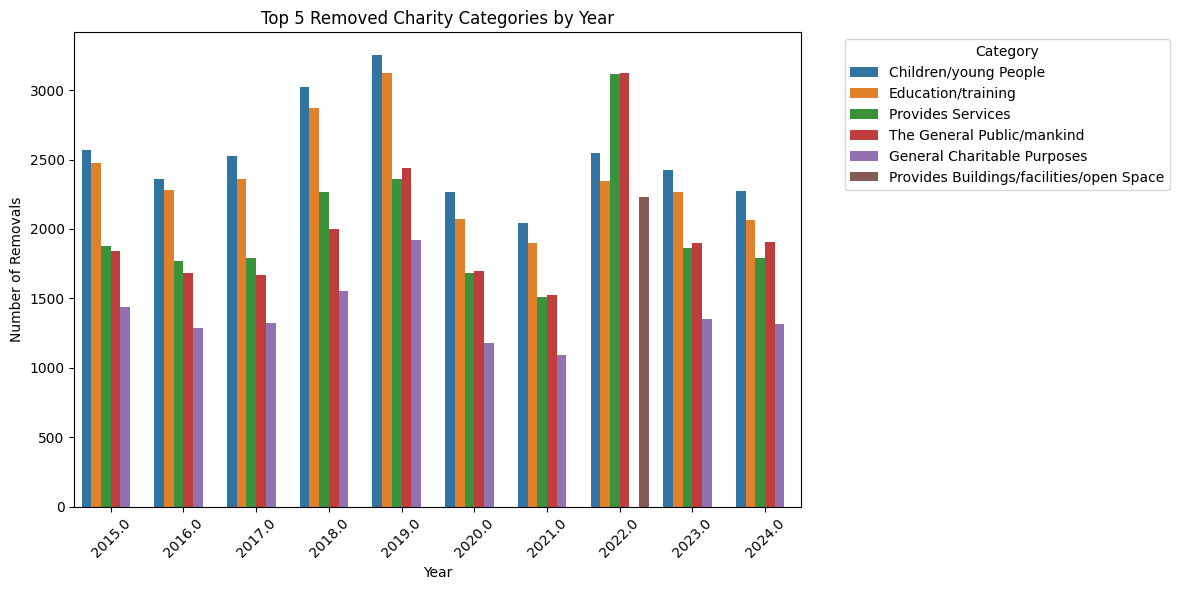

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top5_per_year, x='removal_year', y='count', hue='classification_description')

plt.title("Top 5 Removed Charity Categories by Year")
plt.xlabel("Year")
plt.ylabel("Number of Removals")
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [75]:
# Ensure date format
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['registration_year'] = dataset['date_of_registration'].dt.year

# Filter rows with year and local authority
registered = dataset[dataset['registration_year'].notnull() & dataset['local_authority'].notnull()]

# Group by local authority and year
registered_by_year_la = (
    registered
    .groupby(['local_authority', 'registration_year'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# Keep only years 2015–2024
years = list(range(2015, 2025))
registered_by_year_la = registered_by_year_la[registered_by_year_la.columns.intersection(years)]

# Add total and sort
registered_by_year_la['Total'] = registered_by_year_la.sum(axis=1)
registered_by_year_la = registered_by_year_la.sort_values(by='Total', ascending=False)

# Preview
print("Registered Charities per Year per Local Authority (2015–2024):")
print(registered_by_year_la.head(10))


Registered Charities per Year per Local Authority (2015–2024):
registration_year  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024  \
local_authority                                                                 
Westminster         102   118   104    95   114   112   100    88    77   102   
Birmingham           97    99    86    83    92   116    77    86   106    89   
Camden               76    76    80    66    79    92    59    52    75    84   
Manchester           70    78    87    70    75    83    63    38    63    63   
North Yorkshire      58    86    77    49    67    62    62    52    73    55   
Barnet               59    63    66    47    71    73    51    65    81    52   
Leeds                77    74    44    69    71    66    43    52    58    58   
Hackney              52    75    60    46    49    72    65    56    63    64   
Islington            58    68    73    54    57    63    44    55    54    53   
Cornwall             61    57    75    65    6

In [76]:
# Step 1: Define year range
years = list(range(2015, 2025))

# Step 2: Calculate percentage change across years
registered_pct_change = registered_by_year_la[years].pct_change(axis=1) * 100

# Step 3: Round for readability
registered_pct_change = registered_pct_change.round(2)

# View result
registered_pct_change


registration_year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
local_authority,,,,,,,,,,
Westminster,NaN,15.69,-11.86,-8.65,20.00,-1.75,-10.71,-12.00,-12.50,32.47
Birmingham,NaN,2.06,-13.13,-3.49,10.84,26.09,-33.62,11.69,23.26,-16.04
Camden,NaN,0.00,5.26,-17.50,19.70,16.46,-35.87,-11.86,44.23,12.00
Manchester,NaN,11.43,11.54,-19.54,7.14,10.67,-24.10,-39.68,65.79,0.00
North Yorkshire,NaN,48.28,-10.47,-36.36,36.73,-7.46,0.00,-16.13,40.38,-24.66
...,...,...,...,...,...,...,...,...,...,...
Shetland Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dundee City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Derry City and Strabane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Step 1: Get top 10 local authorities by total registered charities
top15_las = registered_by_year_la.sort_values(by='Total', ascending=False).head(15).index

# Step 2: Subset the % change DataFrame to those LAs
top15_registered_pct_change = registered_pct_change.loc[top15_las]

# Step 3: Drop 2015 (since all % changes there are NaN)
top15_registered_pct_change = top15_registered_pct_change.drop(columns=[2015])

# Step 4: Apply the highlight function
styled_top15 = top15_registered_pct_change.style.apply(highlight_top2_bottom2, axis=1)

# Show
styled_top15


registration_year,2016,2017,2018,2019,2020,2021,2022,2023,2024
local_authority,,,,,,,,,
Westminster,15.690000,-11.860000,-8.650000,20.000000,-1.750000,-10.710000,-12.000000,-12.500000,32.470000
Birmingham,2.060000,-13.130000,-3.490000,10.840000,26.090000,-33.620000,11.690000,23.260000,-16.040000
Camden,0.000000,5.260000,-17.500000,19.700000,16.460000,-35.870000,-11.860000,44.230000,12.000000
Manchester,11.430000,11.540000,-19.540000,7.140000,10.670000,-24.100000,-39.680000,65.790000,0.000000
North Yorkshire,48.280000,-10.470000,-36.360000,36.730000,-7.460000,0.000000,-16.130000,40.380000,-24.660000
Barnet,6.780000,4.760000,-28.790000,51.060000,2.820000,-30.140000,27.450000,24.620000,-35.800000
Leeds,-3.900000,-40.540000,56.820000,2.900000,-7.040000,-34.850000,20.930000,11.540000,0.000000
Hackney,44.230000,-20.000000,-23.330000,6.520000,46.940000,-9.720000,-13.850000,12.500000,1.590000
Islington,17.240000,7.350000,-26.030000,5.560000,10.530000,-30.160000,25.000000,-1.820000,-1.850000


In [80]:
# 1. Drop 'Total' column if it exists
yearly_registered = registered_by_year_la.drop(columns='Total')

# 2. General trend: total registrations per year (all councils)
general_reg_trend = yearly_registered.sum(axis=0)

# 3. % change in the general registration trend
general_reg_pct_change = general_reg_trend.pct_change() * 100
general_reg_pct_change = general_reg_pct_change.round(2)
print("📈 General % Change in Charity Registrations per Year:")
print(general_reg_pct_change)

# 4. Get top 15 councils by total registrations
top15_reg = registered_by_year_la.head(15).drop(columns='Total')

# 5. Calculate % change per council
top15_reg_pct_change = top15_reg.pct_change(axis=1) * 100
top15_reg_pct_change = top15_reg_pct_change.round(2)

# 6. Deviation from general trend
deviation_from_general_reg = top15_reg_pct_change.subtract(general_reg_pct_change, axis=1)

# 7. Filter for strong deviations
strong_reg_deviations = deviation_from_general_reg[deviation_from_general_reg.abs() > 40]

# Output
print("📌 Strong Deviations in Registrations (>±40% from general trend):")
print(strong_reg_deviations.dropna(how='all'))


📈 General % Change in Charity Registrations per Year:
registration_year
2015      NaN
2016    10.96
2017    -6.41
2018   -10.52
2019    16.99
2020    -0.51
2021   -24.70
2022    -6.75
2023    20.47
2024     7.93
dtype: float64
📌 Strong Deviations in Registrations (>±40% from general trend):
registration_year  2015  2016  2017   2018   2019   2020  2021  2022   2023  \
local_authority                                                               
Manchester          NaN   NaN   NaN    NaN    NaN    NaN   NaN   NaN  45.32   
Barnet              NaN   NaN   NaN    NaN    NaN    NaN   NaN   NaN    NaN   
Leeds               NaN   NaN   NaN  67.34    NaN    NaN   NaN   NaN    NaN   
Hackney             NaN   NaN   NaN    NaN    NaN  47.45   NaN   NaN    NaN   
Bristol, City of    NaN   NaN   NaN    NaN  41.55    NaN   NaN   NaN    NaN   

registration_year   2024  
local_authority           
Manchester           NaN  
Barnet            -43.73  
Leeds                NaN  
Hackney            

In [81]:
# Step 1: Parse registration year
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['registration_year'] = dataset['date_of_registration'].dt.year

# Step 2: Standardise charity number format
dataset['registered_charity_number'] = dataset['registered_charity_number'].astype(str).str.strip().str.zfill(6)
df_category['registered_charity_number'] = df_category['registered_charity_number'].astype(str).str.strip().str.zfill(6)

# Step 3: Merge datasets on charity number
merged_reg = pd.merge(dataset, df_category, on='registered_charity_number', how='inner')

# Step 4: Filter for desired registration years
filtered_reg = merged_reg[
    merged_reg['registration_year'].between(2015, 2024)
]

# Step 5: Group by year and category
category_reg_trend = (
    filtered_reg
    .groupby(['registration_year', 'classification_description'])
    .size()
    .reset_index(name='count')
)

# Step 6: Get top 5 categories per year
top5_registered_per_year = (
    category_reg_trend
    .sort_values(['registration_year', 'count'], ascending=[True, False])
    .groupby('registration_year')
    .head(5)
)

# Optional preview
print(top5_registered_per_year)


     registration_year            classification_description  count
32                2015            The General Public/mankind   3320
27                2015                     Provides Services   3122
9                 2015                    Education/training   2738
6                 2015                 Children/young People   2606
12                2015           General Charitable Purposes   1752
66                2016            The General Public/mankind   3625
61                2016                     Provides Services   3389
40                2016                 Children/young People   3136
43                2016                    Education/training   2948
57                2016  Provides Advocacy/advice/information   2360
100               2017            The General Public/mankind   3283
74                2017                 Children/young People   3136
95                2017                     Provides Services   3068
91                2017  Provides Advocacy/advice

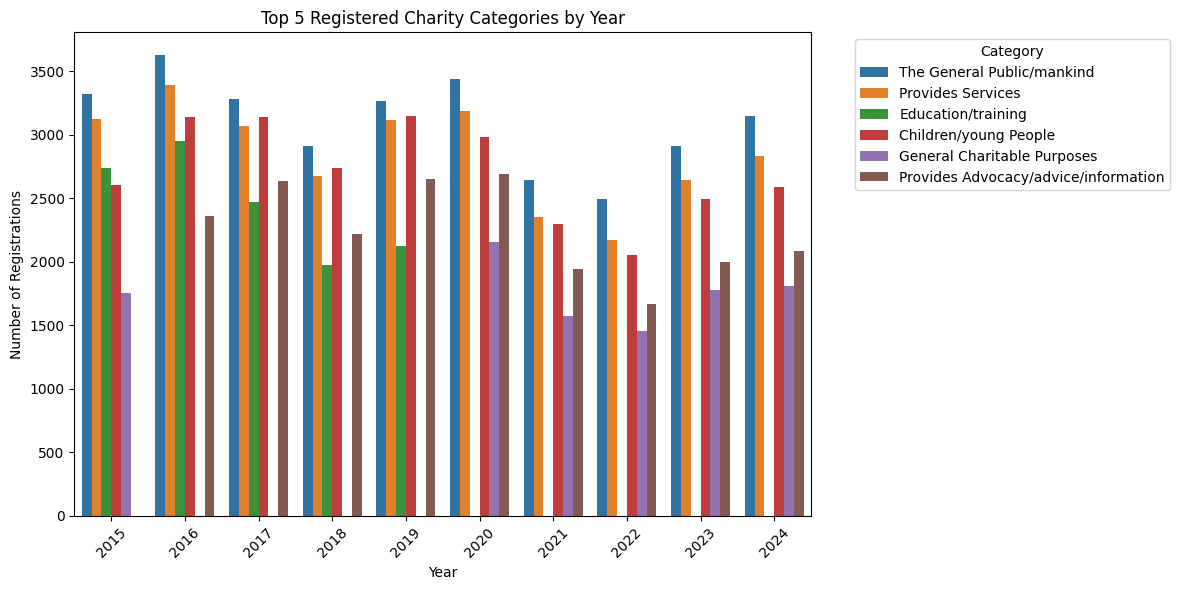

In [82]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top5_registered_per_year,
    x='registration_year',
    y='count',
    hue='classification_description'
)

plt.title("Top 5 Registered Charity Categories by Year")
plt.xlabel("Year")
plt.ylabel("Number of Registrations")
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
